# ⚡ XGBoost Models for Drug Sensitivity Prediction

This notebook trains an **XGBoost regression model per drug** using gene expression features. XGBoost is widely used for structured data due to its speed, regularization, and strong predictive performance. We use **5-fold cross-validation** to evaluate model generalization with both RMSE and R² scores.


In [8]:
import os
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/pseudo_bulk/gdsc_cell_drug_with_pca.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 13)


### 🔁 Train One XGBoost Model Per Drug

For each drug, we train a separate XGBoost regressor using its associated (cell line, IC50, features) data. Performance is evaluated using RMSE and R².


In [10]:
os.makedirs("models_xgb", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        print(f"⚠️ Skipping drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        n_jobs=-1,
        random_state=42,
        verbosity=0
    )

    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    print(f"\n💊 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {-rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
    print(f"  ➤ R²   (folds): {r2_scores.round(4)} | Mean: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

    model.fit(X, y)
    joblib.dump(model, f"models_xgb/xgb_drug_{drug_id}.pkl")



💊 Drug 1 | Samples: 391
  ➤ RMSE (folds): [1.2528 0.9641 0.9862 1.458  1.3483] | Mean: 1.2019 ± 0.1963
  ➤ R²   (folds): [-0.0704 -0.0011 -0.4134 -0.2082 -0.3636] | Mean: -0.2114 ± 0.1601

💊 Drug 3 | Samples: 356
  ➤ RMSE (folds): [2.2637 2.1045 2.5403 2.0447 2.471 ] | Mean: 2.2849 ± 0.1952
  ➤ R²   (folds): [-0.0848 -0.4028 -0.4136 -0.4372 -0.3384] | Mean: -0.3354 ± 0.1295

💊 Drug 5 | Samples: 394
  ➤ RMSE (folds): [1.7105 1.7626 1.7513 1.8459 1.8072] | Mean: 1.7755 ± 0.0468
  ➤ R²   (folds): [-0.0742 -0.3757 -0.0493 -0.1374 -0.2215] | Mean: -0.1716 ± 0.1181

💊 Drug 6 | Samples: 403
  ➤ RMSE (folds): [0.8959 1.1332 0.8981 0.8317 0.9272] | Mean: 0.9372 ± 0.1028
  ➤ R²   (folds): [-0.0996 -0.223  -0.049  -0.0725 -0.1592] | Mean: -0.1207 ± 0.0630

💊 Drug 9 | Samples: 396
  ➤ RMSE (folds): [1.5736 1.4741 1.4226 1.6997 1.5944] | Mean: 1.5529 ± 0.0968
  ➤ R²   (folds): [-0.1288 -0.1522 -0.1484 -0.1666 -0.1353] | Mean: -0.1463 ± 0.0132

💊 Drug 11 | Samples: 393
  ➤ RMSE (folds): [2.2677 2.2

In [11]:
results_df = pd.DataFrame(results)
results_df.to_csv("models_xgb/model_performance_summary.csv", index=False)

print("📁 Saved to models_xgb/model_performance_summary.csv")
results_df.head()


📁 Saved to models_xgb/model_performance_summary.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,1.201865,0.196302,-0.211366,0.160058
1,3,356,2.284855,0.195224,-0.335361,0.129466
2,5,394,1.775498,0.046786,-0.171635,0.118110
3,6,403,0.937223,0.102828,-0.120653,0.063012
4,9,396,1.552888,0.096817,-0.146253,0.013241


### 📊 Distribution of XGBoost Model Performance

These plots visualize the RMSE and R² across all drug-specific models trained using XGBoost.


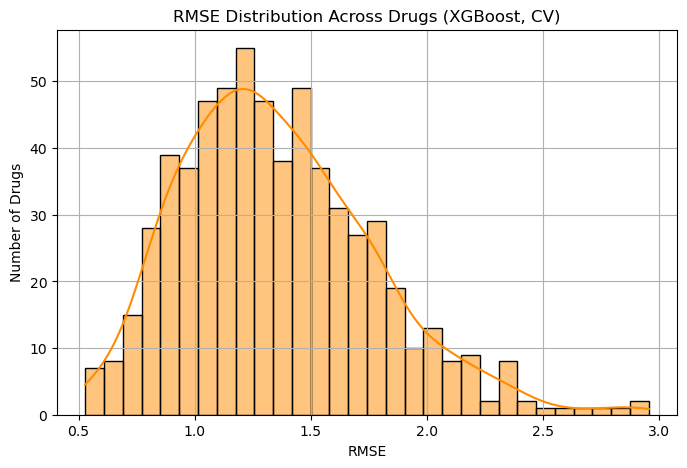

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (XGBoost, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()

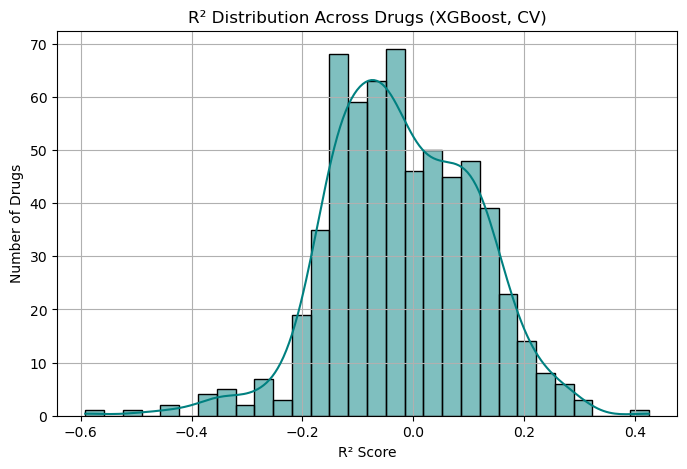

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution Across Drugs (XGBoost, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()